In [1]:
import quadrotor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
# %matplotlib inline
# %matplotlib widget
import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
from typing import Tuple
from qpsolvers import Problem, solve_problem

def controller(x,t):
    return np.zeros(2)

# x_init = np.array([0., 0., 0., 0., 0., 0.])
# horizon_length = 10
# t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)



In [ ]:
class Optimization:
    def __init__(self, m, l, I, dt, g, xdim, udim):
        self.m = m
        self.l = l
        self.I = I
        self.dt = dt
        self.g = g
        self.xdim = xdim
        self.udim = udim

    def quadrotor_dynamics(self, x_init, y, N=100):
        nvar = self.xdim + self.udim
        # Print the shapes
        # print(f"Total shape of y: {y.shape}")
        # print(f"Total shape of x_init: {x_init.shape}")
        y = np.asarray(y).flatten()
        x_init = np.asarray(x_init).flatten()

        # Define the placeholders for A and b
        A = np.zeros((6 * N, nvar * N))
        b = np.zeros(6 * N)

        # Define the initial state constraints
        A[:6, :] = np.eye(6, nvar * N)
        b[:6] = x_init - y[:6]

        # Define the constraints for the rest of the time steps
        for t in range(N-1):
            # Propogate the indices
            i = t * nvar
            n = i
            n1 = i + nvar

            # Assign the variables at time step t
            px = y[n]
            vx = y[n + 1]
            py = y[n + 2]
            vy = y[n + 3]
            theta = y[n + 4]
            omega = y[n + 5]
            u1 = y[n + 6]
            u2 = y[n + 7]

            # Assign the variables at time step t+1
            px_1 = y[n1]
            vx_1 = y[n1 + 1]
            py_1 = y[n1 + 2]
            vy_1 = y[n1 + 3]
            theta_1 = y[n1 + 4]
            omega_1 = y[n1 + 5]

            # Position x constraint
            A[6 * (t+1), n] = 1
            A[6 * (t+1), n + 1] = self.dt
            A[6 * (t+1), n1] = -1
            b[6 * (t+1)] = px + (self.dt * vx) - px_1

            # Velocity x constraint
            A[6 * (t+1) + 1, n + 1] = 1
            A[6 * (t+1) + 1, n + 4] = -self.dt * ((u1 + u2) * np.cos(theta) / self.m)
            A[6 * (t+1) + 1, n + 6] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n + 7] = -self.dt * (np.sin(theta) / self.m)
            A[6 * (t+1) + 1, n1 + 1] = -1
            b[6 * (t+1) + 1] = vx - (self.dt * (u1 + u2) * np.sin(theta) / self.m) - vx_1

            # Position y constraint
            A[6 * (t+1) + 2, n + 2] = 1
            A[6 * (t+1) + 2, n + 3] = self.dt
            A[6 * (t+1) + 2, n1 + 2] = -1
            b[6 * (t+1) + 2] = py + self.dt * vy - py_1
            
            # Velocity y constraint
            A[6 * (t+1) + 3, n + 3] = 1
            A[6 * (t+1) + 3, n + 4] = -self.dt * ((u1 + u2) * np.sin(theta) / self.m)
            A[6 * (t+1) + 3, n + 6] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n + 7] = self.dt * (np.cos(theta) / self.m)
            A[6 * (t+1) + 3, n1 + 3] = -1
            b[6 * (t+1) + 3] = vy + self.dt * (((u1 + u2) * np.cos(theta) / self.m) - 9.81) - vy_1

            # Angle theta constraint
            A[6 * (t+1) + 4, n + 4] = 1
            A[6 * (t+1) + 4, n + 5] = self.dt
            A[6 * (t+1) + 4, n1 + 4] = -1
            b[6 * (t+1) + 4] = theta + self.dt * omega - theta_1

            # Angular velocity omega constraint
            A[6 * (t+1) + 5, n + 5] = 1
            A[6 * (t+1) + 5, n + 6] = self.dt * self.l / self.I
            A[6 * (t+1) + 5, n + 7] = -self.dt * self.l / self.I
            A[6 * (t+1) + 5, n1 + 5] = -1
            b[6 * (t+1) + 5] = omega + self.dt * self.l * (u1 - u2) / self.I - omega_1

        # # Print shapes of A and b
        # print(f"Shape of A: {A.shape}")
        # print(f"Shape of b: {b.shape}")
        return A, b

    def circle_traj_gen(self, k, N):
        des_x = np.cos(-np.pi/2+ 2*np.pi*k/N)
        des_y = 1 + np.sin(-np.pi/2 + (2*np.pi * k/N))

        if (k <= (N/5)):
            des_theta = 0

        elif ((N/5) <= k <= (2*N/5)):
            des_theta = np.pi/2

        elif ((2*N/5) <= k <= (3*N/5)):
            des_theta = np.pi

        elif ((3*N/5) <= k <= (4*N/5)):
            des_theta = 3 * np.pi/2

        elif ((4*N/5) <= k <= N):
            des_theta = 2 * np.pi
        return des_x, des_y, des_theta
    
    

    def QR_cost(self):
        Q = np.diag([10, 1, 10, 1, 10, 1])
        R = np.diag([0.1, 0.1])

        return Q, R

    def cost_function(self, y, x_init, N):
        # Number of variables in state and control
        nvar = self.xdim + self.udim
        y = y.flatten()
        x_init = x_init.flatten()
        mini_Q, mini_R = self.QR_cost()

        # Initialize the cost for N states and N-1 controls
        P = block_diag(*([mini_Q, mini_R] * N))
        q = np.zeros((nvar * N))

        # Loop over the horizon
        for k in range(N):
            des_x, des_y, des_theta = self.circle_traj_gen(k=k, N=N)
            q[(nvar * k):(nvar * k + nvar)] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ mini_Q)).flatten(), [0, 0]))

        q = q.reshape(-1, 1).flatten()
        cost = 0.5 * (y.T @ P @ y) + (q.T @ y)

        # Sanity Check for the shapes
        # print(f"Shape of P: {P.shape}")
        # print(f"Shape of q: {q.shape}")
        # print(f"Shape of y: {y.shape}")
        # print(f"Shape of x_init: {x_init.shape}")

        return cost

    def grad_cost(self, x_init, y, N):
        # Number of variables in state and control
        nvar = self.xdim + self.udim
        x_init = x_init.flatten()
        y = y.flatten()

        mini_Q, mini_R = self.QR_cost()

        P = block_diag(*([mini_Q, mini_R] * N))
        q = np.zeros((nvar * N))

        # # Print the shapes of P and q
        # print(f"Shape of P: {P.shape}")
        # print(f"Shape of q: {q.shape}")

        for k in range(N):
            des_x, des_y, des_theta = self.circle_traj_gen(k=k, N=N)
            q[(nvar * k):(nvar * k + nvar)] = np.concatenate(((-(np.array([[des_x], [0], [des_y], [0], [des_theta], [0]]).T @ mini_Q)).flatten(), [0, 0]))

        grad_f = P @ y + q

        return grad_f


        
    

    def hess_cost(self, N):
        mini_Q, mini_R = self.QR_cost()

        cost_hess = block_diag(*([mini_Q, mini_R] * N))
        # assert cost_hess.shape[0] == cost_hess.shape[1]

        return cost_hess
    

    def state_constraints(self, y: np.ndarray, N: int = 500) -> Tuple[np.ndarray, np.ndarray]:
        
        nvar = self.udim + self.xdim

        y = np.asarray(y).flatten()

        mini_G = np.array([
            [0, 0, 1, 0, 0, 0, 0, 0], 
            [0, 0, -1, 0, 0, 0, 0, 0],  
            [0, 0, 0, 0, 0, 0, 1, 0],  
            [0, 0, 0, 0, 0, 0, -1, 0],  
            [0, 0, 0, 0, 0, 0, 0, 1],  
            [0, 0, 0, 0, 0, 0, 0, -1]   
        ])

        
        G = block_diag(*([mini_G] * N))

        h = np.zeros(6 * N)

        for i in range(N):
            u_1 = y[(i * nvar) + 6]
            u_2 = y[(i * nvar) + 7]

            h[(6 * i)] = 2 - y[(i * nvar) + 2]
            h[(6 * i) + 1] = y[(i * nvar) + 2]
            h[(6 * i) + 2] = 10 - u_1
            h[(6 * i) + 3] = u_1
            h[(6 * i) + 4] = 10 - u_2
            h[(6 * i) + 5] = u_2

        # # Print the shapes of G and h
        # print(f"Shape of G: {G.shape}")
        # print(f"Shape of h: {h.shape}")
        
            

        return G, h


    def KKT_Solver(self, x_init, y, N):
        A, b = self.quadrotor_dynamics(x_init, y, N)
        G, h = self.state_constraints(y, N)
        
        kkt_problem = Problem(P = csr_matrix(self.hess_cost(N)),q = self.grad_cost(x_init, y, N), A = csr_matrix(A), b = -b, G = csr_matrix(G), h = h)
        kkt_sol = solve_problem(problem=kkt_problem, solver="cvxopt")
            
        return kkt_sol
    

    def constaint_violation(self, x_init, y, N):
        nvar = self.xdim + self.udim
        y = np.asarray(y).flatten()
        x_init = np.asarray(x_init).flatten()

        A_prime, b_prime = self.quadrotor_dynamics(x_init, y, N)
        total_violation = np.sum(np.abs(b_prime))
        inequality_violation = 0

        for i in range(N):
            u1 = y[(nvar * i) + 6]
            u2 = y[(nvar * i) + 7]
            if u1 > 10:
                total_violation += np.abs(u1 - 10)
            elif u1 < 0:
                total_violation += np.abs(u1)

            if u2 > 10:
                total_violation += np.abs(u2 - 10)
            elif u2 < 0:
                total_violation += np.abs(u2)

            if y[(nvar * i) + 2] < 0:
                total_violation += np.abs(y[(nvar * i) + 2])

        return total_violation + inequality_violation
    


    def line_search(self, x_init, est_y, N, alpha=1.0, rho=0.5, tol=1e-4, iterations=1000):
        nvar = self.udim + self.xdim

        est_y = np.asarray(est_y).flatten()
        x_init = np.asarray(x_init).flatten()

        # Initialize variables for tracking progress
        least_violation = np.inf
        optimal_cost = np.inf
        cost_list = []
        alpha_list = []
        violation_list = []

        for i in range(iterations):
            smallville = False

            sol = self.KKT_Solver(x_init, est_y, N)
            pk = sol.x
            while ((self.cost_function(y=(est_y + (alpha * pk)), x_init=x_init, N=N) >= optimal_cost) and (self.constaint_violation(x_init, est_y + (alpha * pk), N) >= least_violation)):
                alpha = rho * alpha
                if alpha < 1e-6:
                    smallville = True
                    break

            if smallville:
                break

            least_violation = self.constaint_violation(x_init, est_y + (alpha * pk), N)
            optimal_cost = self.cost_function(y=(est_y + (alpha * pk)), x_init=x_init, N=N)
            alpha_list.append(alpha)
            cost_list.append(optimal_cost)
            violation_list.append(least_violation)
            # Update est_y
            est_y = est_y + (alpha * pk)

            # Termination condition
            if least_violation < tol and i != 0:
                break

        est_y = est_y.reshape(-1, nvar)
        x = est_y[:, :self.xdim].T
        u = est_y[:, self.xdim:].T

        print(f"Convergence reached at iteration {i+1}.")

        return x, u
    

    def controller(self, x_init: np.ndarray, k_init: int, verbose: bool = True):
        """
        Quadrotor controller using filter line search optimization for trajectory tracking.

        Parameters:
        ----------
        x_init : np.ndarray
            Initial state of the quadrotor. Shape: `(DIM_STATE,)`.
        k_init : int
            Initial time step index for trajectory optimization.
        verbose : bool, optional
            If `True`, prints detailed logs during optimization. Default is `True`.

        Returns:
        -------
        np.ndarray
            The control input for the first time step after optimization. Shape: `(DIM_CONTROL,)`.

        Raises:
        ------
        ValueError
            If the optimization fails due to infeasibility or numerical issues.

        Notes:
        ------
        - This function initializes the guess for the state and control trajectories (`y_guess`)
        and optimizes the trajectory over a finite prediction horizon (`TIME_STEPS`).
        - If optimization is successful, it computes the control input and logs key results.
        - If optimization fails, an error message is printed, and garbage collection is performed.
        """
        # Define the prediction horizon
        TIME_STEPS = 50
        print(x_init)
        # Initialize guess for state and control trajectories
        y_guess = np.zeros(
            (self.udim + self.xdim) * TIME_STEPS, dtype=np.float64)
        # Set the initial state in the guess
        y_guess[:quadrotor.DIM_STATE] = x_init

        try:
            # Solve for the optimal trajectory using filter line search
            # x, u = filter_line_search(
            #     x_init=x_init,
            #     y_guess=y_guess,
            #     Q_diag=np.array([31.25, 0.03125, 31.25, 0.03125, 3.125,
            #                     0.03125], dtype=np.float64),  # State weighting
            #     # Control weighting
            #     R_diag=np.array([0.75, 0.75], dtype=np.float64),
            #     N=TIME_STEPS,
            #     verbose=False,
            #     rho=0.5,
            #     tol=1e-4,
            #     k_init=k_init
            # )
            x, u = self.line_search(x_init=x_init, est_y=y_guess, N=TIME_STEPS, alpha=1.0, rho=0.5, tol=1e-4, iterations=1000)

            # Log optimization results if verbose is enabled
            if verbose:
                next_state = quadrotor.next_state(
                    x[:, 0].flatten(), u[:, 0].flatten())
                print(
                    f"For k = {k_init}\n"
                    f"    x_init  = {x[:, 0].flatten()}\n"
                    f"    u = {u[:, 0].flatten()}\n"
                    f"    Next State = {next_state}"
                )

        except ValueError as e:
            # Handle optimization failure
            print(f"Optimization failed at time {k_init * quadrotor.DT}: {e}")

        # Perform garbage collection
        # gc.collect()

        # Return the control input for the first time step
        return u[:, 0].flatten()
    
    def mpc_states(self, x_init: np.ndarray, k_init: int, verbose: bool = True) -> Tuple:
        horizon_length = 10
        t, state, u = quadrotor.simulate(
                x_init,  # Initial state
                self.controller(x_init=x_init,k_init=0,verbose=True),  # Controller function
                horizon_length,  # Simulation length
                disturbance=True  # Enable disturbances
                )
        return t, state, u
    



In [ ]:
N = 100
x_init = np.zeros(6)
est_y = np.zeros(8*N)
rho = 0.5
tol = 1e-4
alpha = 1
opt = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
x, u = opt.line_search(x_init=x_init, est_y=est_y, N=N, alpha=alpha, rho=rho, tol=tol, iterations=1000)


Convergence reached at iteration 25.


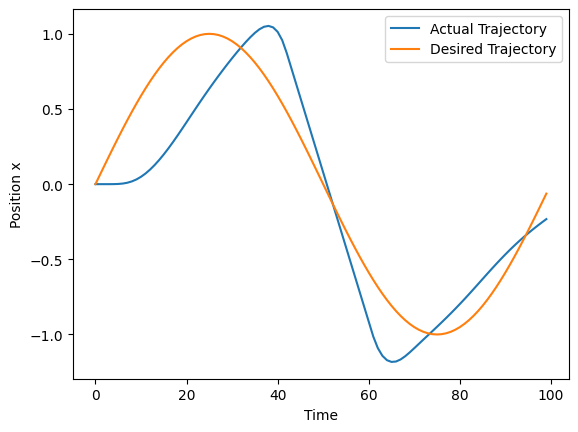

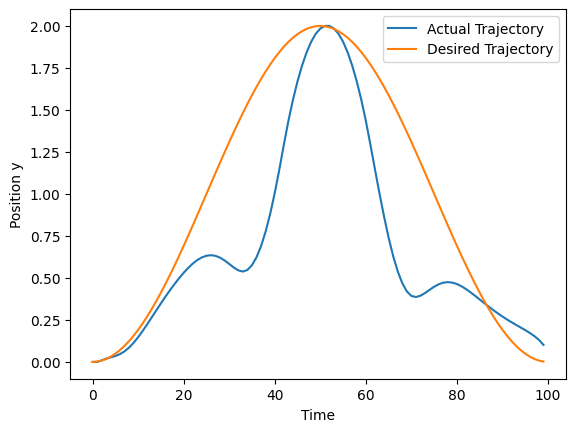

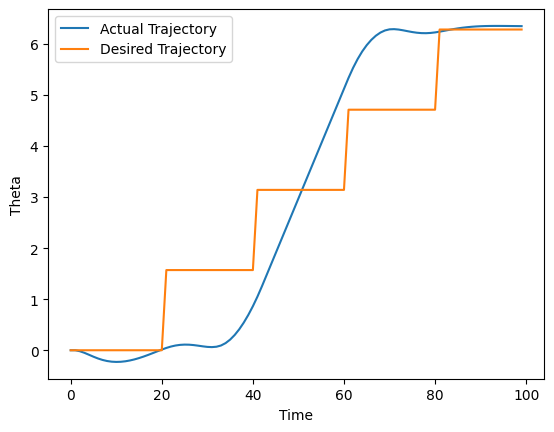

In [4]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.circle_traj_gen(k=i, N=N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the desired and coordinates
plt.figure()
plt.plot(x[0, :], label="Actual Trajectory")
plt.plot(x_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Position x")
plt.legend()
plt.show()  

plt.figure()
plt.plot(x[2, :], label="Actual Trajectory")
plt.plot(y_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Position y")
plt.legend()
plt.show()

plt.figure()
plt.plot(x[4, :], label="Actual Trajectory")
plt.plot(theta_traj, label="Desired Trajectory")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.show()


In [5]:
quadrotor.animate_robot(x,u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAYqhtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EVNliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY57OK1qhW2q1YsEhxxt2AAAAwAADHt3Oj1r582TADmF4VOeAGBsAQrW
eR/AZREVN442xgxRfMgNY6JiSzI+yy8spWi2aTheyw0WYP70ibuWiEfV+iuNmMwQiKRcJPMedVYV
o76NlqXz32+8YQyvrjFDndJnj1+CXRw5YE1mO/PrMd4tFBzjb8dJ1BM48vIL35BplhtY3rNX1siz
7GbExK1mDjqSJnP//JqyH2rp3NIYBygdQBYxlMe/J/olUhRL5b7qAVcC2nJIsQ1fta0zXYkcH2SA
IMbRlwKE/xjdYaqySLM4H5NTxtoo9MSjMILh0QjcIh0EpNOalG5/618L8yn7mkNKgUKzJHdWdbvP
/QjZDKZt5ga07l9eODvzenV5qD8fw1J+wZr3pqmHBdl4/3U+g1Q5ABb2/wjr1kwKDD/oQrAv8+6/
NUAvMmUd6SwQZqs3gk9AZpc56GzMOnv/UOvRCIFTk3013E5uim2/viAGKBLb6QMx7zfdFMyyYG1Y
i/9Y9MIU/oGdaoYDnrGIkKIA+sPjTF2TfcnJ4AAUizr/UesAKQIj9SDbqPzRjYyYfHiizE7RJ/0R
Df/MbCjEBBQJsjADcRruQaHdTTKv3f54YEWIp5DWFL88mSpEjgbufsWibv3VQoka627jvOO+PAZo
TaAwL8cjngQV/5ob3thPImfs/q1N5T6vECYUUjoHse3v+tdN7uWCc2jgK+k4GzxBT5RyU0HPINQC
DvJuqNn2L+IZuTm+NW43sVLnleA3kOy51Kmiulhu1Vow7W04+r4udm/W+Fh9fXeMQXNipqlYwT/O
nlNGSKq3RWRSAM6erveqLOlsNeenDi465P+vmqhpSUODVDmR1kqGmzvk2/NW6/L//F7waAXx01Vy
ytqWe2FAyE3DZkt+3JL8JsPT7Epbc7fAVwgE75ReLXM8G+P8Ple5sHQD4X53gB5T6qmN+MMj/uNW
cmKGBoETxw5hTPF+dLdW9CH+qCmT2hU5XPa5Kz+6szVRYZlsZI81T3n7BblQ/MD6yXTXaneeIv9w
LwLMmnggAGAADM8D9bp2qTWF57hKZ4I+N4XL7a/TAZSsNg/XlY8wyjGsS52ZpZbcwDGcEYG1/rDg
/0lQZoLNgfXb1s7G3u6gW2uTNGdCG//hUXsTyXOpslk1dfLqySNn1h1vc8FT1xuQapI9JoOcsRuA
3FXOz9giH6F0gOXicVmxtLqsgUCLwfukVlJDkRAvsA9HT4WW13q+HcVidSIugmg0iem4NmACnvmJ
dcFtPI7ZjBG4+vurFmC4r4gmPr3aQKOcLM75z9v7T6ySMgnUGHYwOCF7S8KPXoU+Val1zvSth1Do
FAbWj8VVawmU/N7mtGkgvBymI6ClpapMI+sv9EJwl2J23ejYrI/fj9AF8IgJmYRVlD+OXOFssxsj
PNGZ0uBKC6Kw/4uSXM73R4SEP+xMqwcnul+kbC9nzH5bmjaydUXzaQ1GCqo4b8h7Un8lmU0snDC/
Mf29n/ICiKHuQehs2LxoW

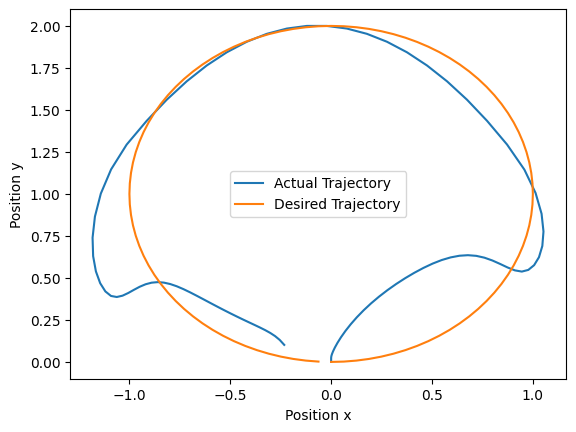

In [6]:
traj = Optimization(quadrotor.MASS, quadrotor.LENGTH, quadrotor.INERTIA, quadrotor.DT, quadrotor.GRAVITY_CONSTANT, quadrotor.DIM_STATE, quadrotor.DIM_CONTROL)
# Store the desired trajectory
x_traj = np.zeros(N)
y_traj = np.zeros(N)
theta_traj = np.zeros(N)

for i in range(N):
    des_x, des_y, des_theta = traj.circle_traj_gen(k=i, N=N)
    x_traj[i] = des_x
    y_traj[i] = des_y
    theta_traj[i] = des_theta



# Plot the trajectory in 2D
plt.figure()
plt.plot(x[0, :], x[2, :], label="Actual Trajectory")
plt.plot(x_traj, y_traj, label="Desired Trajectory")
plt.xlabel("Position x")
plt.ylabel("Position y")
plt.legend()
plt.show()



In [7]:
# import numpy as np
# import gc

# controller = opt.controller(x_init, k_init=0, verbose=True)

print(f"Control input at k = 0: {controller}")

t, states, u = opt.mpc_states(x_init, k_init=0, verbose=True)
# # Simulation parameters
# horizon_length = 300  # Total simulation horizon length

# # Simulate the quadrotor's trajectory
# t, state, u = quadrotor.simulate(
#     x_init,  # Initial state
#     opt.controller(x_init=x_init,k_init=0,verbose=True),  # Controller function
#     horizon_length,  # Simulation length
#     disturbance=True  # Enable disturbances
# )

# Animate the quadrotor's trajectory
# quadrotor.animate_robot(state, u)

Control input at k = 0: <function controller at 0x778f757c6560>
[0. 0. 0. 0. 0. 0.]
Convergence reached at iteration 10.
For k = 0
    x_init  = [-1.48637669e-31  1.31778517e-17  7.69295314e-22  6.70127781e-13
  5.11754661e-18  1.52184733e-17]
    u = [1.67695897e-11 9.86732394e+00]
    Next State = [ 5.27114067e-19  9.13813247e-18  2.68051120e-14  3.96985915e-01
  5.72628554e-18 -5.92039436e-01]


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAKjltZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ESBliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8
dV/vzdPNgHyNMPd7Qeurp1KvON9Kpiiq9WLcXgAu6rO4VJF3rAEt8s69kj217dTvtZESV+cTFtXm
3MWiO6d6NaNes2JxyIga8j/MW3CqBIXjhkLWvdScKZvg8MVaqrvYXuPHtXdox+2jtMl6rE9m/6s+
6Cy5TIeNjaXXn1STQyWNTn8r0KGY5XUU8YWj4rZIaUkBqvdT8HuUUf+o5XJ26+3LKiBErocn6j49
qq8oSXOlEJOrVByQ/AJBrvhIWmp7Arh1AuEuWsSZb82qwUX4YpLA+jhMqj8m793/30LpXeFCUvZ2
UCe1W6p2YBPju3XCRbv1SUWh+PCzX/y/JOTn5daKAGqplfjh5srEeY/c4vSTRR95J8M5n4/TGcAx
LQ3PrLHc2GMPnZEJfxoC+wBYhBAypi/Fy9xMI1ucvHymIu5d422tynfquHUyrPs+EoGJWAKSh7sA
/1MVNHQEZn8PVx0E7zdACzSSpOOGTWhaF57lTZmwv25AAm1RWpQZQNAjDBwssbGzn7T9AUYvB5TR
OC2Y81b4lVRo85K9ALdVT88zTm3NQJtghKkRdRSpqhUtIrjCZKMykOlm2t9EO0rQF5ZuCfH/lz+/
UwWvmDPTn9cTK5z3Vxl7LtLEbhh5Vfx71ieysrD8L/9IQmf+q2zFJh7Sh+8YpRuqdP1EIbAeOEuG
IyXAZ8dExE3ggS3C04yJjAgtHFPfwoCk4e5VyD1+YVxVKaQ+yeMF6HGK7M7BdG0++ViQSUecZkcy
q1tCyReJ2zQBZtiL+Q3loxtWdewSaQ+NnVN7fG8qziVfQ55Fst86EHRbfp6enX6l609SVLqc8hcx
f/fCQwUA3xUgn9ALzX/KIqIs204slWYN4Bk3i0PMdv4mAPQ3kYPhLZ2GJFrqmMsOmKKc+fGkIXiC
sZIoKF5Reli6qIvktB/sjAAAAwAAAwJFsjA4IkNwgAA9uSydKQoAAhPDEJrYbP3KymRGga1Uuohm
xKhZH2Yn5lK0WzScL2WGjTB/ekTdy0Qj6v0Vxsxl9IRSLhPGYqw4lo0h9Gy1L577forFFKRxihz6
kzx6/BLo4iiyYv2hjdbN8Wig5xtYr1wGNx0Kh8FGJplZtY3rNX1siz7GbExK2ilgZoY3IvSqyG+r
p3NIYBygdQBY9goi6QL9EqkIaGSrTtqhKxkTDBLEtNZR2edrWma7E3g+yP982UMI29crGN1hqrJI
sAdZcmpsSFv1gxyAqWPDU+Q69NZpvwdBLDTmpRvofObvwJs5BpBS2ZMilSRfF1u9AGczTLWcC+UL
X4lkG8IXzenV5qEBH03ivpFCD9wDWjZ05uvdU01DbXowzey0AtYPkYfX+P5rgYizEZgwr01X5Ck5
nJ51IvA1Uz6kljEu5HqEf4HAFwFg+rpoL8xXWThhAu3eAC6fsgR9Pn241QYZSgf9C3U4R+xghB7w
AT/guQhf751FoRhrvXk4xaB7ksAAAAMAGOFE8ZJdemhhei/zfjA0kBqKhKgBIprxdkQhu/oiG/+Y
2FGICCfrMPZJ6Q4cTHCTyBQn1/zwwIsRYIedvo9VUJRKmdtGWnigm9IOKhT2uqRg7zjvjwGaEywM
C/HI54EFf+aGT7YTw6WddfRTnT6cxMdVuW1C0iu6PNED+3f1HRY3o7BDZ4op8o5KaDnkGmgg9W7q
jZ9i/h5u0j41hfexUueV4DeQ7LiAiHbGh/XL9jKbeVm/mqWeJtkBLEQ6FAYFX9FQanHJDJ5iwBMn
6XSbQLoMDHw8Ca379fzop79OWRPCYpP9EZtIgmgCRL4FhX06cGovCQqiZcbQb9oBVGTy24lPfgR6
RZ4fQtqkQ/C8rkftBBDINHzPRB0nOK34ROD9QuPBzI5dtUktvmjw6hWs1JblGRTsbSRdHWjGqrAX
Gduk/A9dXpDUCBg4ES8w53EpX9N4zp+pv2M9wuA3H9zdSo+k8g+YKfpwUvIRokIWNHQAQhx3pJnl
Oe07OceRcfQBCbNm5wlNLxxBisl9tfpgMpWGv0q1DPnWRAisRnP5qlLgAPRfKxI/27u38EhtyxLL
GEys6WuXsNN0E/zOQ4/XXBYg1wAa+y1v8xxcmB6EKs4Cv0cUZf6jpAYGJQ5PFsBJpxdY/g3b9d9a
yRizZPPSyQmp8HTKi/LX7yN9DgAAAwAAGMKjF7ZKQZXPYW1KznIuQvS964sit5RWAtyozfO9+Zjb
4ZMarABV+JnaCbycaTu4OcACJWdx7mTbc7Z6hM7LrwSts5O4QeVqaOyOz9B14gk7MEQoRudbWNg2
M35Y8FylXK2SjKLDZV9wGy2JMLvjSnqyM6fbIA5HRXYDRHb8stQat9TQw+7dV+avHPe9HJ9iT3QN
5uqBdBuE+CvTPOz2/zJZptn8jl+6c3gfs36cLpWX9LKcdBOa3WETgxejiHQupEFOdfoc3Aiwufy1
4ilo76d/Jy1pu3RWcvCkc